In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from lightgbm import LGBMRegressor

import eli5
from eli5.sklearn import PermutationImportance

import re

##### Data Load and Setting

- 데이터로드

In [ ]:
# train / test 로드
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

# 외부데이터 로드
bus = pd.read_csv('./Data/bus_feature.csv')
subway = pd.read_csv('./Data/subway_feature.csv')
elementary = pd.read_csv('./Data/elementary_school_feature.csv')
middle = pd.read_csv('./Data/middle_school_feature.csv')
high = pd.read_csv('./Data/high_school_feature.csv')
interest = pd.read_csv('./Data/base_interest_rate.csv')
mortgage = pd.read_csv('./Data/mortgage_rate.csv')

- train/test 를 합치고, 전용면적 컬럼명 통일

In [3]:
train['is_test'] = 0
test['is_test'] = 1

concat = pd.concat([train, test], ignore_index = True)
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

print('concat Shape : ', concat.shape)
display(concat.head(3))

concat Shape :  (1128094, 53)


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0


##### EDA

- Target EDA

In [4]:
# Target 값 (즉, 대회에서 맞춰야 될 값) 은 Train에만 존재
train_only = concat.query('is_test == 0') .copy()

target = train_only['target']

print('target 기본 통계 요약')
print(target.describe())

print('0이하 값 개수 : ', (target <= 0).sum())
print('고유값 개수 : ', target.nunique())

target 기본 통계 요약
count    1.118822e+06
mean     5.799153e+04
std      4.642602e+04
min      3.500000e+02
25%      3.050000e+04
50%      4.480000e+04
75%      6.980000e+04
max      1.450000e+06
Name: target, dtype: float64
0이하 값 개수 :  0
고유값 개수 :  14530


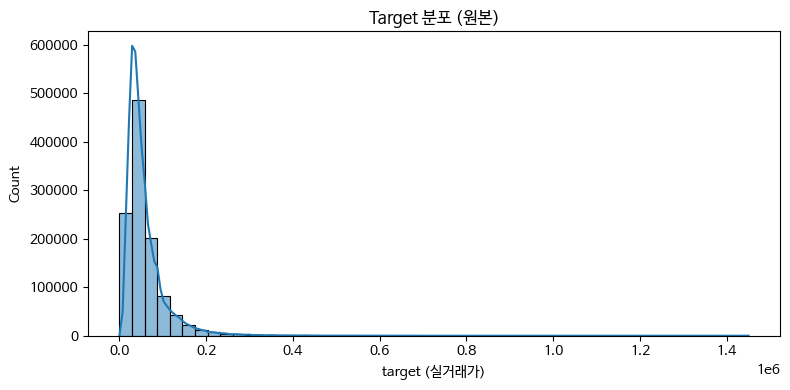

In [5]:
# Target 히스토그램
plt.figure(figsize=(8, 4))
sns.histplot(target, bins=50, kde=True)
plt.title("Target 분포 (원본)")
plt.xlabel("target (실거래가)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

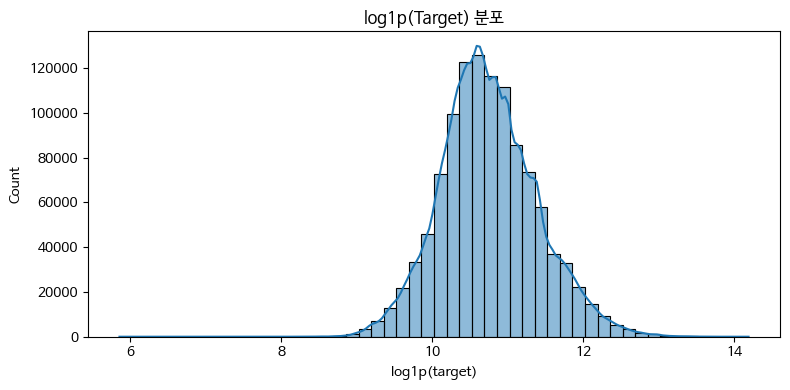


log1p(target) 기본 통계
count    1.118822e+06
mean     1.075095e+01
std      6.374883e-01
min      5.860786e+00
25%      1.032551e+01
50%      1.070999e+01
75%      1.115340e+01
max      1.418707e+01
Name: target, dtype: float64


In [6]:
# Target log1p 분포 (큰 값의 영향을 완화했을 때 분포가 얼마나 고르게 변하는지 체크)
target_log = np.log1p(target)

plt.figure(figsize=(8, 4))
sns.histplot(target_log, bins=50, kde=True)
plt.title("log1p(Target) 분포")
plt.xlabel("log1p(target)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("\nlog1p(target) 기본 통계")
print(target_log.describe())

In [7]:
# 분위수 확인
quantiles = target.quantile([0.01, 0.05, 0.5, 0.95, 0.99, 0.995, 0.999])
print("target 주요 분위수(quantiles)")
print(quantiles)

target 주요 분위수(quantiles)
0.010     11500.0
0.050     17000.0
0.500     44800.0
0.950    143500.0
0.990    240000.0
0.995    290000.0
0.999    430000.0
Name: target, dtype: float64


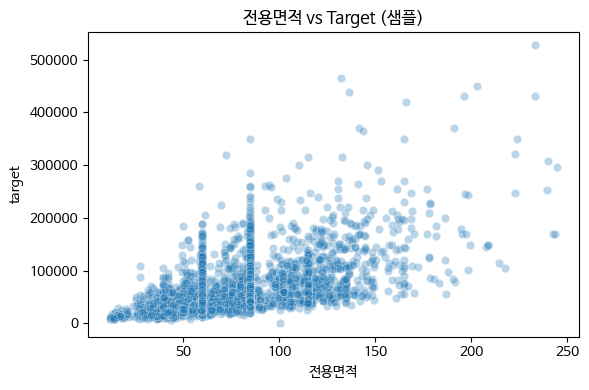

In [8]:
# 전용면적 vs Target 산점도
# 면적이 커질수록 가격이 어떻게 변하는지, 같은 평형에서 수직으로 퍼지는 패턴이 있는지
plt.figure(figsize=(6, 4))
sns.scatterplot(data = train_only.sample(min(5000, len(train_only)), random_state = 42), x = "전용면적", y="target", alpha = 0.3)
plt.title("전용면적 vs Target (샘플)")
plt.xlabel("전용면적")
plt.ylabel("target")
plt.tight_layout()
plt.show()

- 시간(계약년월) EDA

In [9]:
# 계약년 / 계약월 파생 컬럼 만들기
# 즉 '계약년월' -> '계약년' , '계약월' 로 분리
train_only = concat.query("is_test == 0").copy()

train_only["계약년월"] = train_only["계약년월"].astype(str)
train_only["계약년"]   = train_only["계약년월"].str[:4].astype(int)
train_only["계약월"]   = train_only["계약년월"].str[4:].astype(int)

train_only[["계약년월", "계약년", "계약월"]].head()

,계약년월,계약년,계약월
0,201712,2017,12
1,201712,2017,12
2,201712,2017,12
3,201801,2018,1
4,201801,2018,1


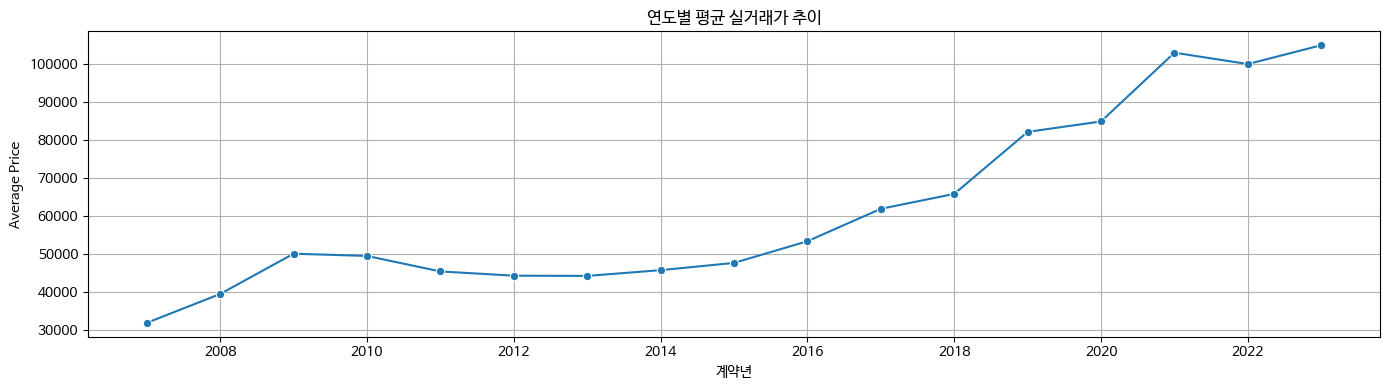

In [10]:
# 연도별 평균 실거래가
yearly_price = train_only.groupby("계약년")["target"].mean().reset_index()

plt.figure(figsize=(14, 4))
sns.lineplot(data=yearly_price, x="계약년", y="target", marker="o")
plt.title("연도별 평균 실거래가 추이")
plt.xlabel("계약년")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

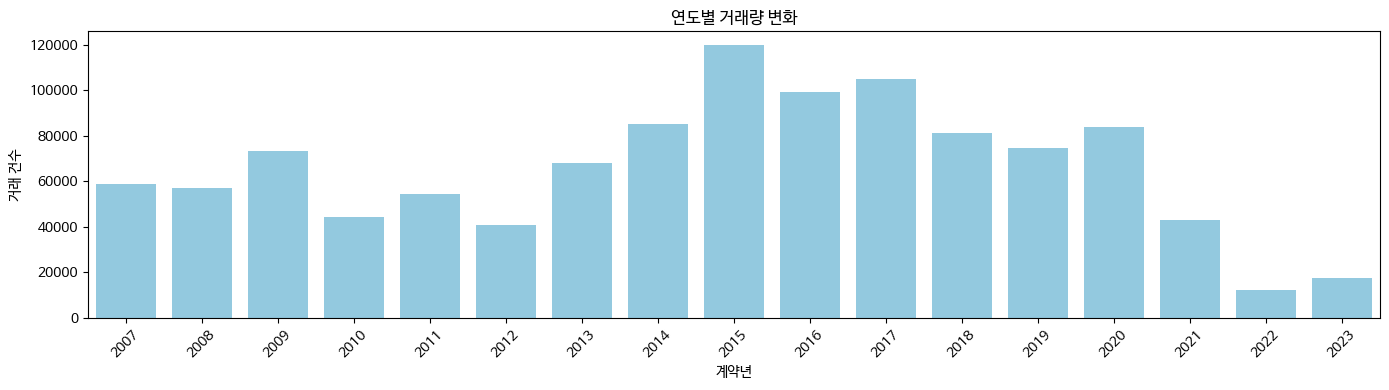

In [11]:
# 연도별 거래량
yearly_count = train_only.groupby("계약년")["target"].count().reset_index()

plt.figure(figsize=(14, 4))
sns.barplot(data=yearly_count, x="계약년", y="target", color="skyblue")
plt.title("연도별 거래량 변화")
plt.xlabel("계약년")
plt.ylabel("거래 건수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

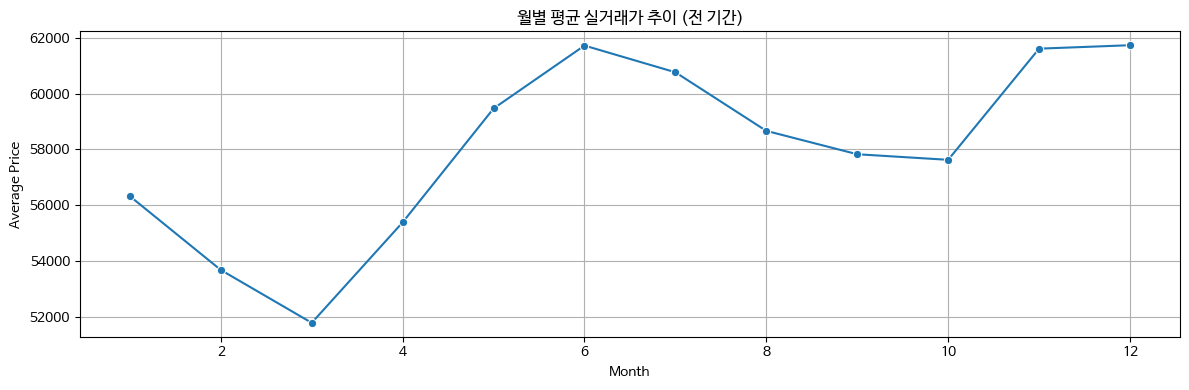

In [12]:
# 월별 평균 실거래가
monthly_price = train_only.groupby("계약월")["target"].mean().reset_index()

plt.figure(figsize=(12, 4))
sns.lineplot(data=monthly_price, x="계약월", y="target", marker="o")
plt.title("월별 평균 실거래가 추이 (전 기간)")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

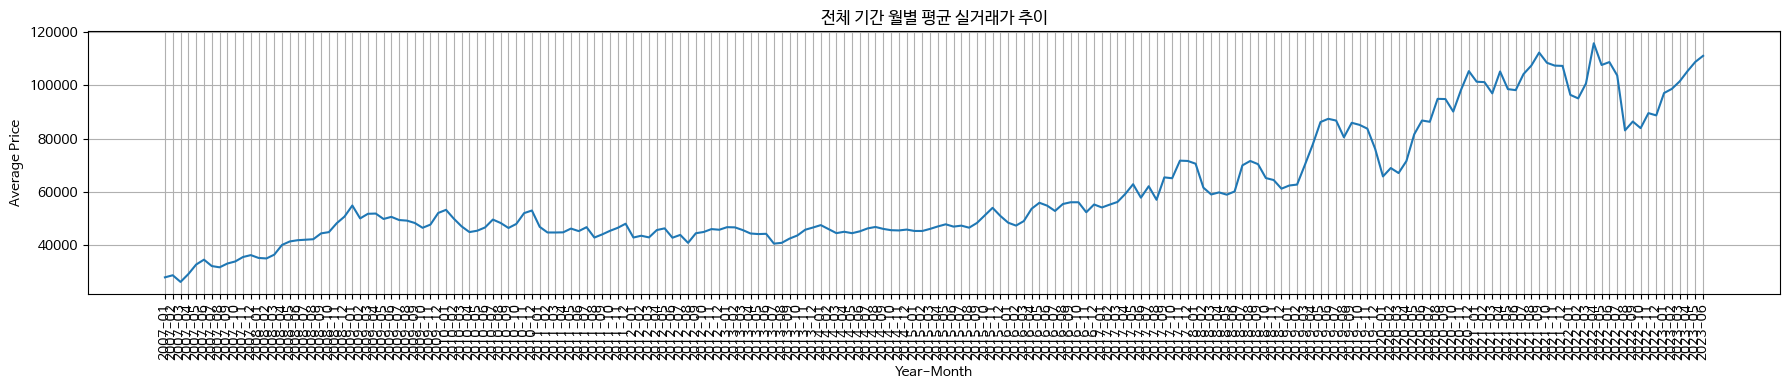

In [13]:
# YM(연, 월) 기준 시계열
# 'YYYY-MM' 단위로 월별 평균 실거래가 추이 확인
train_only["YM"] = (
    train_only["계약년"].astype(str) + "-" + train_only["계약월"].astype(str).str.zfill(2)
)

ym_price = train_only.groupby("YM")["target"].mean().reset_index()

plt.figure(figsize=(18, 4))
sns.lineplot(data=ym_price, x="YM", y="target")
plt.title("전체 기간 월별 평균 실거래가 추이")
plt.xlabel("Year-Month")
plt.ylabel("Average Price")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

- 지역(시/구/동, 강남4구) EDA

In [14]:
# 시/군/구 를 시 / 구 / 동 으로 분리
train_only = concat.query("is_test == 0").copy()

addr_split = train_only["시군구"].str.split()

train_only["시"] = addr_split.str[0]
train_only["구"] = addr_split.str[1]
train_only["동"] = addr_split.str[2]

print(train_only[["시군구", "시", "구", "동"]].head())
print("구(unique) 개수:", train_only["구"].nunique())
print("동(unique) 개수:", train_only["동"].nunique())

             시군구      시    구    동
0  서울특별시 강남구 개포동  서울특별시  강남구  개포동
1  서울특별시 강남구 개포동  서울특별시  강남구  개포동
2  서울특별시 강남구 개포동  서울특별시  강남구  개포동
3  서울특별시 강남구 개포동  서울특별시  강남구  개포동
4  서울특별시 강남구 개포동  서울특별시  강남구  개포동
구(unique) 개수: 25
동(unique) 개수: 337


In [15]:
# 구별 평균 실거래가
gu_price = train_only.groupby("구")["target"].mean().sort_values(ascending=False)

print("구 개수:", len(gu_price))
print("\n평균가 상위 5개 구:\n", gu_price.head())
print("\n평균가 하위 5개 구:\n", gu_price.tail())

구 개수: 25

평균가 상위 5개 구:
 구
강남구    114847.461503
서초구    113608.653390
용산구    105876.961900
송파구     83868.032920
성동구     68924.389400
Name: target, dtype: float64

평균가 하위 5개 구:
 구
강북구    38316.975201
중랑구    35195.762819
노원구    33870.444730
금천구    33709.248647
도봉구    31924.613711
Name: target, dtype: float64


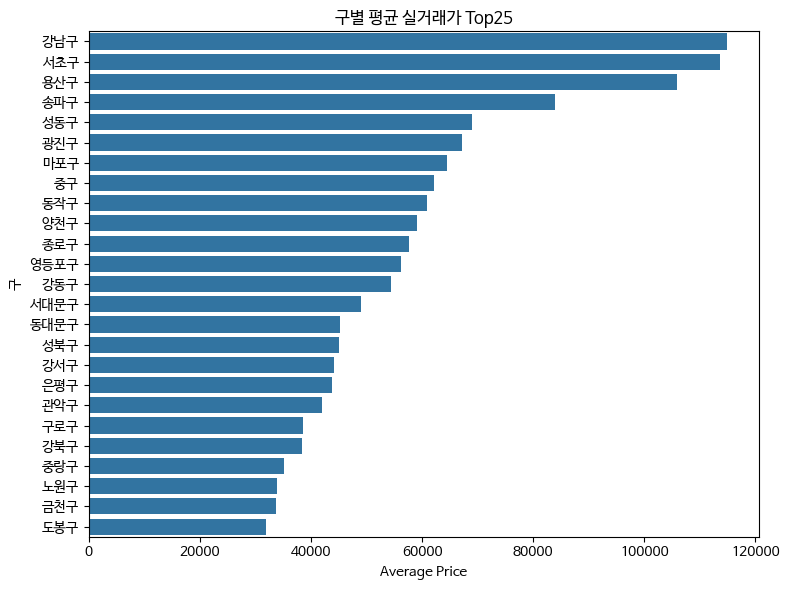

In [16]:
# 상위 25개 구 시각화
top25 = gu_price.head(25)

plt.figure(figsize=(8, 6))
sns.barplot(x=top25.values, y=top25.index)
plt.title("구별 평균 실거래가 Top25")
plt.xlabel("Average Price")
plt.ylabel("구")
plt.tight_layout()
plt.show()

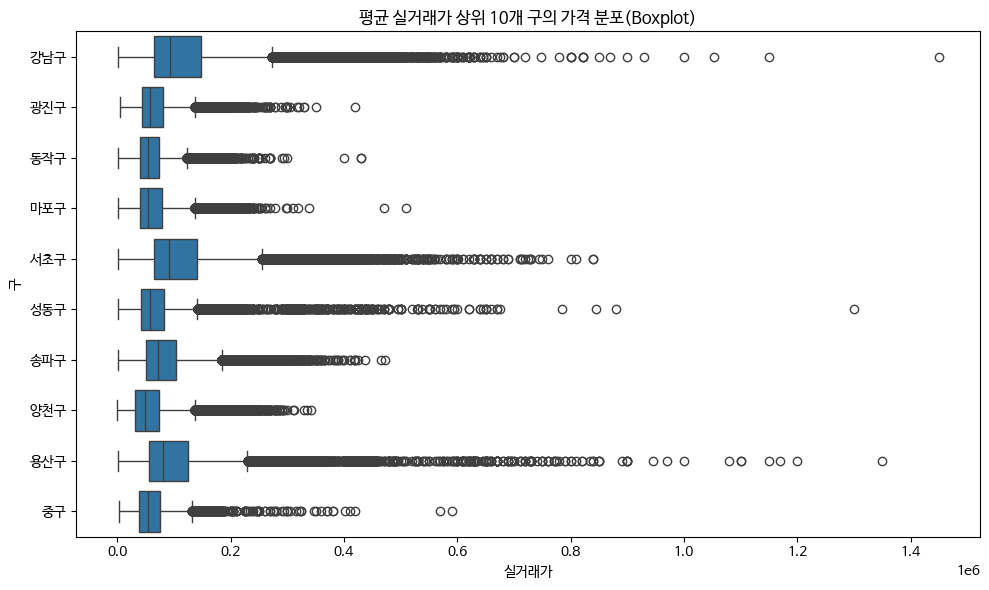

In [17]:
# 평균가 상위 10개의 구의 가격 분포
top10_gu = gu_price.head(10).index.tolist()
top10_data = train_only[train_only["구"].isin(top10_gu)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=top10_data, x="target", y="구")
plt.title("평균 실거래가 상위 10개 구의 가격 분포(Boxplot)")
plt.xlabel("실거래가")
plt.ylabel("구")
plt.tight_layout()
plt.show()

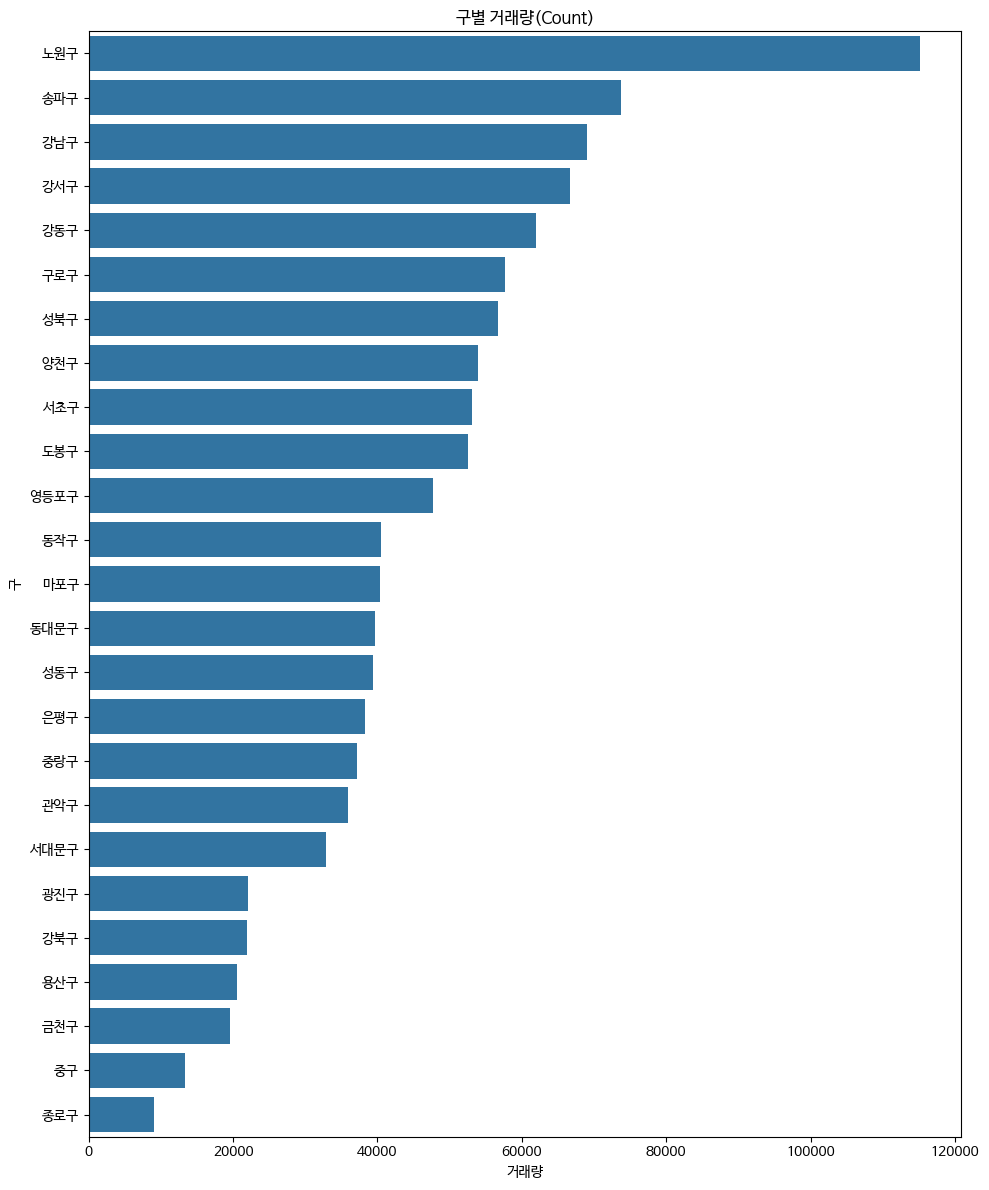

거래량 상위 5구:
 구
노원구    115099
송파구     73785
강남구     69083
강서구     66610
강동구     61895
Name: target, dtype: int64

거래량 하위 5구:
 구
강북구    21896
용산구    20551
금천구    19586
중구     13388
종로구     9101
Name: target, dtype: int64


In [18]:
# 구별 거래량
gu_count = train_only.groupby("구")["target"].count().sort_values(ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=gu_count.values, y=gu_count.index)
plt.title("구별 거래량(Count)")
plt.xlabel("거래량")
plt.ylabel("구")
plt.tight_layout()
plt.show()

print("거래량 상위 5구:\n", gu_count.head())
print("\n거래량 하위 5구:\n", gu_count.tail())

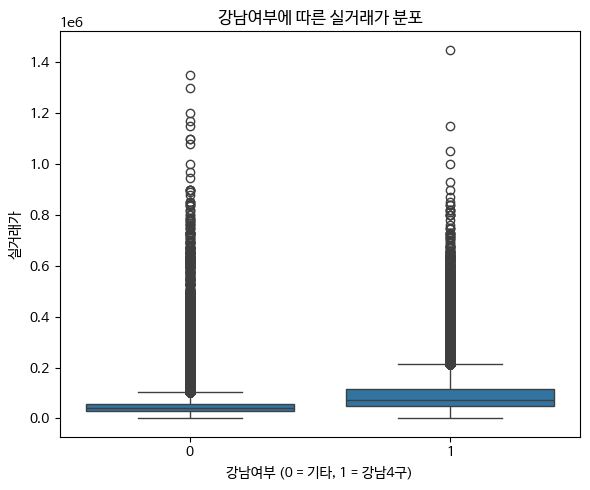

강남 평균 가격 : 91221.60745126779
그 외 평균 가격: 48037.597418149846


In [19]:
# 강남4구 vs 그외 지역 비교
gangnam_list = ["강남구", "서초구", "송파구", "강동구"]

train_only["강남여부"] = train_only["구"].apply(lambda x: 1 if x in gangnam_list else 0)

plt.figure(figsize=(6, 5))
sns.boxplot(data=train_only, x="강남여부", y="target")
plt.title("강남여부에 따른 실거래가 분포")
plt.xlabel("강남여부 (0 = 기타, 1 = 강남4구)")
plt.ylabel("실거래가")
plt.tight_layout()
plt.show()

print("강남 평균 가격 :", train_only[train_only["강남여부"] == 1]["target"].mean())
print("그 외 평균 가격:", train_only[train_only["강남여부"] == 0]["target"].mean())

- 결측치 EDA

In [20]:
# 각 데이터셋 결측 개수/비율
datasets = {
    "train": train,
    "test": test,
    "bus": bus,
    "subway": subway,
    "elementary_school": elementary,
    "middle_school": middle,
    "high_school": high,
}

for name, df_ in datasets.items():
    null_count = df_.isnull().sum().sum()
    null_ratio = null_count / (df_.shape[0] * df_.shape[1])
    print(f"{name} - 총 결측치 개수: {null_count}, 결측률: {null_ratio:.4f}")

train - 총 결측치 개수: 33290792, 결측률: 0.5614
test - 총 결측치 개수: 254608, 결측률: 0.5281
bus - 총 결측치 개수: 0, 결측률: 0.0000
subway - 총 결측치 개수: 0, 결측률: 0.0000
elementary_school - 총 결측치 개수: 1302, 결측률: 0.0731
middle_school - 총 결측치 개수: 844, 결측률: 0.0742
high_school - 총 결측치 개수: 383, 결측률: 0.0410


In [21]:
# 각 데이터셋 컬럼별 결측치 상위 10개
for name, df_ in datasets.items():
    print(f"\n[{name}] 결측치 상위 10개 컬럼")
    display(df_.isnull().sum().sort_values(ascending=False).head(10))


[train] 결측치 상위 10개 컬럼


k-135㎡초과      1118495
해제사유발생일       1112839
k-등록일자        1107832
단지소개기존clob    1050240
k-홈페이지        1005647
고용보험관리번호       913304
세대전기계약방법       878747
k-팩스번호         872742
k-시행사          871254
청소비관리형태        871178
dtype: int64


[test] 결측치 상위 10개 컬럼


k-135㎡초과              9270
해제사유발생일               9060
단지소개기존clob            8718
k-등록일자                8554
k-홈페이지                7876
고용보험관리번호              7453
세대전기계약방법              6642
k-팩스번호                6606
k-단지분류(아파트,주상복합등등)    6582
k-시행사                 6580
dtype: int64


[bus] 결측치 상위 10개 컬럼


노드 ID     0
정류소번호     0
정류소명      0
X좌표       0
Y좌표       0
정류소 타입    0
dtype: int64


[subway] 결측치 상위 10개 컬럼


역사_ID    0
역사명      0
호선       0
위도       0
경도       0
dtype: int64


[elementary_school] 결측치 상위 10개 컬럼


학교특성       614
폐교일자       609
우편번호        42
주소내역        35
경도           1
위도           1
상세주소내역       0
폐교여부         0
남녀공학 구분      0
홈페이지 주소      0
dtype: int64


[middle_school] 결측치 상위 10개 컬럼


학교특성          392
폐교일자          390
우편번호           28
주소내역           25
남녀공학 구분         1
학교도로명 우편번호      1
설립유형            1
경도              1
개교기념일           1
설립일             1
dtype: int64


[high_school] 결측치 상위 10개 컬럼


폐교일자          318
우편번호           30
주소내역           25
학교도로명 상세주소      2
학교도로명 주소        2
학교도로명 우편번호      2
남녀공학 구분         1
학교특성            1
경도              1
위도              1
dtype: int64

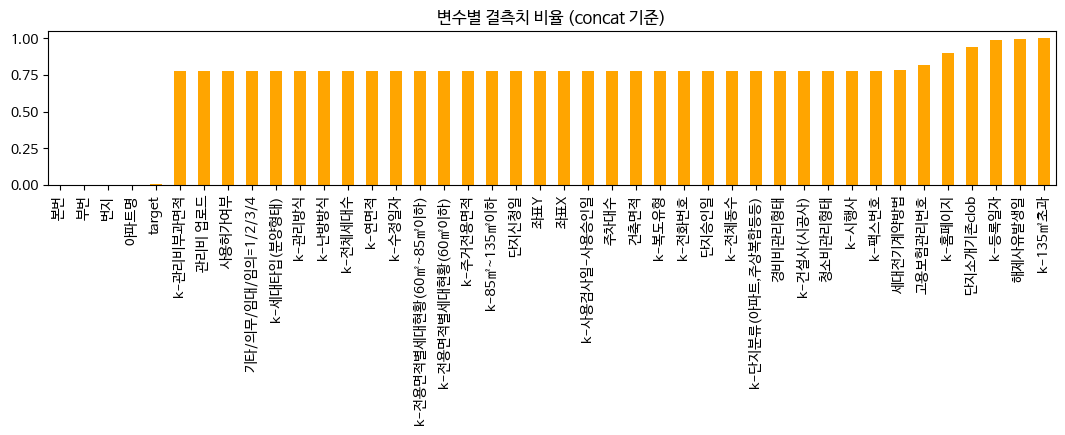

In [22]:
# concat 기준 결측 비율 바 차트
missing_ratio = concat.isnull().sum() / concat.shape[0]
missing_ratio = missing_ratio[missing_ratio > 0].sort_values()

plt.figure(figsize=(13, 2))
missing_ratio.plot.bar(color="orange")
plt.title("변수별 결측치 비율 (concat 기준)")
plt.tight_layout()
plt.show()

In [23]:
# 중요 컬럼별 결측/이상치 패턴 확인
important_cols = [
    "시군구", "번지", "본번", "부번", "아파트명",
    "전용면적", "계약년월", "계약일", "층", "건축년도",
    "해제사유발생일",
]

df_all = concat  # train+test 전체

for col in important_cols:
    print("\n" + "=" * 60)
    print(f"[컬럼명] {col}")

    # 1) NaN 개수
    print(" - NaN 개수:", df_all[col].isnull().sum())

    # 2) unique 샘플
    try:
        print(" - unique 샘플:", df_all[col].dropna().unique()[:5])
    except Exception as e:
        print(" - unique 샘플 표시 불가:", e)

    # 3) 값 분포 상위 5개
    print(" - 상위 value_counts:")
    print(df_all[col].value_counts(dropna=False).head(5))

    # 4) 이상한 값 체크
    weird_values = [" ", "-", "", "NULL", "null", ".", 0]
    print(" - weird value 존재 여부:")

    if df_all[col].dtype == "object":
        for w in weird_values:
            cnt = (df_all[col] == w).sum()
            if cnt > 0:
                print(f"    → '{w}' 값 {cnt}개 존재")
    else:
        cnt0 = (df_all[col] == 0).sum()
        if cnt0 > 0:
            print(f"    → '0' 값 {cnt0}개 존재")


[컬럼명] 시군구
 - NaN 개수: 0
 - unique 샘플: ['서울특별시 강남구 개포동' '서울특별시 강남구 논현동' '서울특별시 강남구 대치동' '서울특별시 강남구 도곡동'
 '서울특별시 강남구 삼성동']
 - 상위 value_counts:
시군구
서울특별시 노원구 상계동    45232
서울특별시 노원구 중계동    26524
서울특별시 양천구 신정동    23768
서울특별시 도봉구 창동     23222
서울특별시 구로구 구로동    22941
Name: count, dtype: int64
 - weird value 존재 여부:

[컬럼명] 번지
 - NaN 개수: 227
 - unique 샘플: ['658-1' '652' '12-2' '141' '187']
 - 상위 value_counts:
번지
13     4670
17     4600
10     4577
347    4291
481    4191
Name: count, dtype: int64
 - weird value 존재 여부:

[컬럼명] 본번
 - NaN 개수: 75
 - unique 샘플: [658. 652.  12. 141. 187.]
 - 상위 value_counts:
본번
30.0     7105
17.0     5538
13.0     5284
271.0    5015
1.0      4989
Name: count, dtype: int64
 - weird value 존재 여부:
    → '0' 값 152개 존재

[컬럼명] 부번
 - NaN 개수: 75
 - unique 샘플: [1. 0. 2. 3. 4.]
 - 상위 value_counts:
부번
0.0    827096
1.0     95543
2.0     28015
3.0     18100
5.0     14026
Name: count, dtype: int64
 - weird value 존재 여부:
    → '0' 값 827096개 존재

[컬럼명] 아파트명
 - NaN 개수: 2136
 - unique 샘플: 

##### 결측치 처리 01 - 의미없는 값 처리 | 본번 부번 및 다른 변수 NaN 값 처리

In [24]:
# 의미 없는 값들을 NaN 으로 치환
df = concat.copy()

# 의미 없는 값 → NaN
df["등기신청일자"] = df["등기신청일자"].replace(" ", np.nan)
df["거래유형"]     = df["거래유형"].replace("-", np.nan)
df["중개사소재지"] = df["중개사소재지"].replace("-", np.nan)

df.isnull().sum().sort_values(ascending=False).head(10)

k-135㎡초과      1127765
해제사유발생일       1121899
k-등록일자        1116386
등기신청일자        1111271
중개사소재지        1090013
거래유형          1086451
단지소개기존clob    1058958
k-홈페이지        1013523
고용보험관리번호       920757
세대전기계약방법       885389
dtype: int64

In [25]:
# 본번 / 부번 / 아파트명 / 번지 / 해제사유일발생일 결측치 처리
# 1. 본번이 0일 경우 NaN (본번이 0은 결측치가 맞다.), indicator
df["본번"] = df["본번"].replace(0, np.nan)
df["본번_missing"] = df["본번"].isnull().astype(int)

# 2. 부번의 경우는 0 일 수가 있다. 따라서 NaN 의 경우만 indicator
df["부번_missing"] = df["부번"].isnull().astype(int)

# 그리고 본번 / 부번의 경우 범주형으로 사용할 예정이므로 문자열로 변환
df["본번"] = df["본번"].astype(str)
df["부번"] = df["부번"].astype(str)

# 3. 아파트명 값이 NaN 일 경우 -> UnKnown
df["아파트명"] = df["아파트명"].fillna("Unknown")
df["아파트명_missing"] = (df["아파트명"] == "Unknown").astype(int)

# 4. 번지의 경우도 NaN -> UnKnown
df["번지"] = df["번지"].fillna("Unknown")
df["번지_missing"] = (df["번지"] == "Unknown").astype(int)

# 5. 해제사유발생일 (해제된 적 있음 / 없음) 에 해당하는 값 처리
df["has_cancelled"] = df["해제사유발생일"].notnull().astype(int)
df["해제사유발생일"] = df["해제사유발생일"].astype(float)

# Check
df.isnull().sum().sort_values(ascending=False).head(15)

k-135㎡초과      1127765
해제사유발생일       1121899
k-등록일자        1116386
등기신청일자        1111271
중개사소재지        1090013
거래유형          1086451
단지소개기존clob    1058958
k-홈페이지        1013523
고용보험관리번호       920757
세대전기계약방법       885389
k-팩스번호         879348
k-시행사          877834
청소비관리형태        877751
k-건설사(시공사)     877637
경비비관리형태        877561
dtype: int64

In [26]:
# 위 과정의 전처리가 잘 들어갔는지 Check

print("▶ 본번_missing 값 분포")
print(df["본번_missing"].value_counts(dropna=False))

print("\n▶ 부번_missing 값 분포")
print(df["부번_missing"].value_counts(dropna=False))

print("\n▶ 아파트명_missing 값 분포")
print(df["아파트명_missing"].value_counts(dropna=False))

print("\n▶ 번지_missing 값 분포")
print(df["번지_missing"].value_counts(dropna=False))

print("\n▶ has_cancelled 값 분포")
print(df["has_cancelled"].value_counts(dropna=False))

display(df[["본번", "본번_missing", "부번", "부번_missing", "아파트명", "아파트명_missing", "번지", "번지_missing", "has_cancelled"]].head())


▶ 본번_missing 값 분포
본번_missing
0    1127867
1        227
Name: count, dtype: int64

▶ 부번_missing 값 분포
부번_missing
0    1128019
1         75
Name: count, dtype: int64

▶ 아파트명_missing 값 분포
아파트명_missing
0    1125958
1       2136
Name: count, dtype: int64

▶ 번지_missing 값 분포
번지_missing
0    1127867
1        227
Name: count, dtype: int64

▶ has_cancelled 값 분포
has_cancelled
0    1121899
1       6195
Name: count, dtype: int64


,본번,본번_missing,부번,부번_missing,아파트명,아파트명_missing,번지,번지_missing,has_cancelled
0,658.0,0,1.0,0,개포6차우성,0,658-1,0,0
1,658.0,0,1.0,0,개포6차우성,0,658-1,0,0
2,658.0,0,1.0,0,개포6차우성,0,658-1,0,0
3,658.0,0,1.0,0,개포6차우성,0,658-1,0,0
4,658.0,0,1.0,0,개포6차우성,0,658-1,0,0


##### 결측치 처리 02 - 수치형/범수형 결측치 처리

In [27]:
# 수치형 / 범주형 컬럼을 분리하고 결측 개수 요약
numeric_cols = []
categorical_cols = []

for col in df.columns:
    # is_test, target 등도 타입 기준으로 자동 분류되게 둠
    if pd.api.types.is_numeric_dtype(df[col]):
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

print("수치형 컬럼 개수 : ", len(numeric_cols))
print("범주형 컬럼 개수 : ", len(categorical_cols))

print("\n[수치형 컬럼]")
print(numeric_cols[:40])

print("\n[범주형 컬럼]")
print(categorical_cols[:40])

# 각 그룹별 결측 총합
num_missing = df[numeric_cols].isnull().sum().sort_values(ascending=False)
cat_missing = df[categorical_cols].isnull().sum().sort_values(ascending=False)

print("\n수치형 컬럼별 결측 개수 Top 15")
display(num_missing.head(15))

print("\n범주형 컬럼별 결측 개수 Top 15")
display(cat_missing.head(15))

수치형 컬럼 개수 :  27
범주형 컬럼 개수 :  31

[수치형 컬럼]
['전용면적', '계약년월', '계약일', '층', '건축년도', '해제사유발생일', '단지소개기존clob', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '본번_missing', '부번_missing', '아파트명_missing', '번지_missing', 'has_cancelled']

[범주형 컬럼]
['시군구', '번지', '본번', '부번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']

수치형 컬럼별 결측 개수 Top 15


k-135㎡초과                  1127765
해제사유발생일                   1121899
단지소개기존clob                1058958
k-전체동수                     877207
건축면적                       876279
주차대수                       876277
좌표Y                        876232
좌표X                        876232
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-전용면적별세대현황(60㎡이하)         876170
k-85㎡~135㎡이하               876170
k-주거전용면적                   876170
k-관리비부과면적                  876125
k-연면적                      876125
k-전체세대수                    876125
dtype: int64


범주형 컬럼별 결측 개수 Top 15


k-등록일자                1116386
등기신청일자                1111271
중개사소재지                1090013
거래유형                  1086451
k-홈페이지                1013523
고용보험관리번호               920757
세대전기계약방법               885389
k-팩스번호                 879348
k-시행사                  877834
청소비관리형태                877751
k-건설사(시공사)             877637
경비비관리형태                877561
k-단지분류(아파트,주상복합등등)     877273
단지승인일                  876854
k-전화번호                 876850
dtype: int64

In [28]:
# 결측이 존재하는 수치형 컬럼만 파악
num_missing_nonzero = num_missing[num_missing > 0]

print("결측이 존재하는 수치형 컬럼 수 : ", len(num_missing_nonzero))
display(num_missing_nonzero)

결측이 존재하는 수치형 컬럼 수 :  16


k-135㎡초과                  1127765
해제사유발생일                   1121899
단지소개기존clob                1058958
k-전체동수                     877207
건축면적                       876279
주차대수                       876277
좌표Y                        876232
좌표X                        876232
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-전용면적별세대현황(60㎡이하)         876170
k-85㎡~135㎡이하               876170
k-주거전용면적                   876170
k-관리비부과면적                  876125
k-연면적                      876125
k-전체세대수                    876125
target                       9272
dtype: int64

In [29]:
# 결측이 존재하는 범주형 컬럼 파악
cat_missing_nonzero = cat_missing[cat_missing > 0]

print("결측이 존재하는 범주형 컬럼 수 :", len(cat_missing_nonzero))
display(cat_missing_nonzero)

결측이 존재하는 범주형 컬럼 수 : 25


k-등록일자                 1116386
등기신청일자                 1111271
중개사소재지                 1090013
거래유형                   1086451
k-홈페이지                 1013523
고용보험관리번호                920757
세대전기계약방법                885389
k-팩스번호                  879348
k-시행사                   877834
청소비관리형태                 877751
k-건설사(시공사)              877637
경비비관리형태                 877561
k-단지분류(아파트,주상복합등등)      877273
단지승인일                   876854
k-전화번호                  876850
k-복도유형                  876454
k-사용검사일-사용승인일           876259
단지신청일                   876187
k-수정일자                  876170
기타/의무/임대/임의=1/2/3/4     876125
사용허가여부                  876125
관리비 업로드                 876125
k-난방방식                  876125
k-관리방식                  876125
k-세대타입(분양형태)            876125
dtype: int64

#### 수치형 변수에 대한 해석값
1. 수치형 변수의 경우 값을 0으로 보간하거나 다른 수치로 보간 할 경우 향후 파생변수 제작에 영향이 갈 수 있음
2. 또한 LightGBM 의 경우 NaN 값을 따로 분류하여 학습을 진행하기 때문에 NaN 에 해당하는 요소들에 굉장히 강함
3. 또한 수치형 변수에서 중요도로 뽑히는 [전용면적, 층, 건축년도, 계약일, 계약년월] 같은 변수들은 결측값이 거의 없는 수준이기 때문에
4. 따라서 수치형 변수는 결측치 처리를 하지 않는다.

In [30]:
# 수치형 변수 중 층에 대한 음수값 처리
# 지하1층의 주거공간 형태를 이용하는 형태를 볼 수 있지만 지하2층 부터는 보기 힘들다고 판단하여 -2 부터 -4 까지 값은 절댓값처리
df.loc[df["층"] < -1, "층"] = df.loc[df["층"] < -1, "층"].abs()

In [31]:
# 범주형 컬럼에 대한 결측치 처리를 어떻게 진행할지 grouping
cat_fill_unknown = [
    "시군구", "번지", "본번", "부번", "아파트명", "도로명",
    "등기신청일자", "거래유형", "중개사소재지",
    "k-단지분류(아파트,주상복합등등)",
    "k-세대타입(분양형태)",
    "k-관리방식",
    "k-복도유형",
    "k-난방방식",
    "k-건설사(시공사)",                       # 대우, 현대, 삼성 등 브랜드 프리미엄 가능성
    "k-시행사",
    "경비비관리형태",
    "세대전기계약방법",
    "청소비관리형태",
    "기타/의무/임대/임의=1/2/3/4",
    "사용허가여부",
    "관리비 업로드",
    "k-사용검사일-사용승인일",                 # 나중에 날짜 파생변수 후보라 보존
    "단지승인일",                             # 일단 살려보고 필요시 나중에 드롭
    "단지신청일"                              # 마찬가지로 보존
]

# 드롭할 범주형 컬럼들 (고유 ID/연락처/홈페이지/등록·수정일자/보험번호 등)
cat_drop = [
    "k-전화번호",
    "k-팩스번호",
    "k-홈페이지",
    "k-등록일자",
    "k-수정일자",
    "고용보험관리번호"
]

print("Unknown으로 채울 컬럼들 (cat_fill_unknown) : ")
print(cat_fill_unknown)

print("\n드롭할 컬럼들 (cat_drop) : ")
print(cat_drop)

Unknown으로 채울 컬럼들 (cat_fill_unknown) : 
['시군구', '번지', '본번', '부번', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', 'k-사용검사일-사용승인일', '단지승인일', '단지신청일']

드롭할 컬럼들 (cat_drop) : 
['k-전화번호', 'k-팩스번호', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호']


In [32]:
# 범주형 결측 처리
df_processed = df.copy()

# 1.NaN → 'Unknown' 처리
for col in cat_fill_unknown:
    if col in df_processed.columns:
        before_na = df_processed[col].isnull().sum()
        df_processed[col] = df_processed[col].fillna("Unknown")
        after_na = df_processed[col].isnull().sum()
        print(f"[fillna] {col}: {before_na} → {after_na}")
    else:
        print(f"[WARN] {col} 컬럼이 df_processed에 없습니다. (스킵)")

# 2.드롭할 컬럼 제거
drop_existing = [col for col in cat_drop if col in df_processed.columns]

df_processed = df_processed.drop(columns=drop_existing)

print("드롭된 컬럼 : ", drop_existing)
print("df_processed shape : ", df_processed.shape)

[fillna] 시군구: 0 → 0
[fillna] 번지: 0 → 0
[fillna] 본번: 0 → 0
[fillna] 부번: 0 → 0
[fillna] 아파트명: 0 → 0
[fillna] 도로명: 0 → 0
[fillna] 등기신청일자: 1111271 → 0
[fillna] 거래유형: 1086451 → 0
[fillna] 중개사소재지: 1090013 → 0
[fillna] k-단지분류(아파트,주상복합등등): 877273 → 0
[fillna] k-세대타입(분양형태): 876125 → 0
[fillna] k-관리방식: 876125 → 0
[fillna] k-복도유형: 876454 → 0
[fillna] k-난방방식: 876125 → 0
[fillna] k-건설사(시공사): 877637 → 0
[fillna] k-시행사: 877834 → 0
[fillna] 경비비관리형태: 877561 → 0
[fillna] 세대전기계약방법: 885389 → 0
[fillna] 청소비관리형태: 877751 → 0
[fillna] 기타/의무/임대/임의=1/2/3/4: 876125 → 0
[fillna] 사용허가여부: 876125 → 0
[fillna] 관리비 업로드: 876125 → 0
[fillna] k-사용검사일-사용승인일: 876259 → 0
[fillna] 단지승인일: 876854 → 0
[fillna] 단지신청일: 876187 → 0
드롭된 컬럼 :  ['k-전화번호', 'k-팩스번호', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호']
df_processed shape :  (1128094, 52)


In [33]:
# 범주형 결측치 처리가 잘 되었는지 Check
categorical_cols_processed = df_processed.select_dtypes(exclude=[np.number]).columns

cat_missing_after = (
    df_processed[categorical_cols_processed]
    .isnull()
    .sum()
    .sort_values(ascending=False)
)

print("범주형 결측 처리 후 남아 있는 결측 Top 20")
display(cat_missing_after.head(20))

범주형 결측 처리 후 남아 있는 결측 Top 20


시군구                    0
k-난방방식                 0
관리비 업로드                0
사용허가여부                 0
단지승인일                  0
기타/의무/임대/임의=1/2/3/4    0
청소비관리형태                0
세대전기계약방법               0
경비비관리형태                0
k-사용검사일-사용승인일          0
k-시행사                  0
k-건설사(시공사)             0
k-복도유형                 0
번지                     0
k-관리방식                 0
k-세대타입(분양형태)           0
k-단지분류(아파트,주상복합등등)     0
중개사소재지                 0
거래유형                   0
등기신청일자                 0
dtype: int64

- 금리 외부데이터는 '한국은행 기준금리' 에 제공된 데이터로 결측치가 존재하지 않음
- (변동성만 알려주는 데이터기 때문에 따로 결측치 처리 X)

##### Data Save

In [34]:
save_path = './Data/01_eda_end/preprocessed_concat.pkl'

with open(save_path, "wb") as f:
    pickle.dump(df_processed, f)

print('저장 경로 : ', save_path)
print('Shape : ', df_processed.shape)

저장 경로 :  ./Data/01_eda_end/preprocessed_concat.pkl
Shape :  (1128094, 52)
